## Relax Take Home

### Summary

The percentage of users who are defined as 'adopted user' is 13.3%. To find which factors predict future user adoption, I did the following:
- created the 'adopted' column as 1 for adopted and 0 for not
- created a column 'creation_code' which is the creation_source coded to a numeric value
- created a column 'invited_bool' which indicates a boolean invited by another user or not 1 or 0.
- used the following factors
    - opted_in_to_mailing_list
    - enabled_for_marketing_drip
    - org_id
    - invited_bool
    - creation_code
    
From those factors, I ran a pearson correlation matrix to see their correlation to adoption. This didn't reveal much information at all.

Plotting the percent of adopted to not adopted for each creation_code showed the following:
- creation source 'personal projects' was least likely to become an adopted user
- 'guest invite' and 'signup google auth' were more likely to become an adopted user

Finally, I ran a quick random forests classifier with default parameters to get the feature importance results. It turns out, org_id is the factor most predictive of future adoption. Plotting this, we can see some org_id's have a high adoption rate and some have very low adoption rates.

In summary, org_id is most predictive factor followed by creation_source. Everything else didn't show much.

To go further, we could see if email has an affect by getting the email domain for each person. Also, creation time might have a correlation to adoption. These two factors could be explored.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.ensemble import RandomForestClassifier

In [4]:
df1 = pd.read_csv('./takehome_users.csv', encoding='latin1')
df2 = pd.read_csv('./takehome_user_engagement.csv')

In [170]:
len(df1.invited_by_user_id.unique())

2565

In [53]:
df2.time_stamp = pd.to_datetime(df2.time_stamp)

In [54]:
df3 = df2.groupby(['user_id', 'time_stamp']).count()

In [101]:
adopted=[]
for idx in df3.index.get_level_values(0).unique():
    if df3.loc[(idx, slice(None))].resample('D').count().rolling(7).sum().max().iloc[0] >= 3:
        adopted.append(idx)

In [163]:
print('Percent of adopted users to total: ', len(adopted)/len(df1.object_id))

Percent of adopted users to total:  0.13308333333333333


In [118]:
df1['adopted'] = df1.object_id.isin(adopted).astype(int)

In [126]:
df1['invited_bool'] = df1.invited_by_user_id.clip_upper(1)

In [130]:
df1.invited_bool = df1.invited_bool.fillna(0)

In [133]:
df1['creation_code'] = df1.creation_source.astype('category').cat.codes

In [135]:
df4 = df1[['opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'org_id', 'invited_bool', 'creation_code', 'adopted']]

In [137]:
df4.corr()

,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_bool,creation_code,adopted
opted_in_to_mailing_list,1.000000,0.483529,0.003432,0.006934,-0.004563,0.008815
enabled_for_marketing_drip,0.483529,1.000000,0.009275,0.002216,0.001282,0.005173
org_id,0.003432,0.009275,1.000000,-0.018442,0.012143,0.064366
invited_bool,0.006934,0.002216,-0.018442,1.000000,-0.866293,0.028039
creation_code,-0.004563,0.001282,0.012143,-0.866293,1.000000,-0.004157
adopted,0.008815,0.005173,0.064366,0.028039,-0.004157,1.000000


In [155]:
create_perc = (df4.groupby('creation_code')['adopted'].sum() / df4.groupby('creation_code')['adopted'].count())

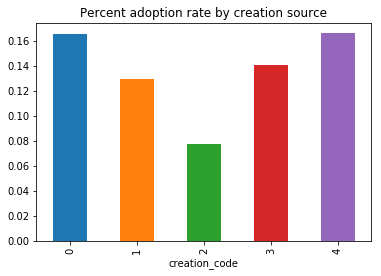

In [167]:
create_perc.plot.bar(title='Percent adoption rate by creation source')

In [146]:
X = df4.drop('adopted', axis=1)
y = df4.adopted

In [147]:
rf_clf = RandomForestClassifier()
rf_clf.fit(X, y)


C:\Users\robin\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [149]:
dfcolumns = pd.DataFrame(X.columns)
df_rfscores = pd.DataFrame(rf_clf.feature_importances_)
feat_rf_scores = pd.concat([dfcolumns, df_rfscores], axis=1)
feat_rf_scores.columns = ['Feature','Score'] 
feat_rf_scores.nlargest(10, 'Score')

,Feature,Score
2,org_id,0.951614
4,creation_code,0.023202
1,enabled_for_marketing_drip,0.012450
0,opted_in_to_mailing_list,0.009534
3,invited_bool,0.003199


In [157]:
org_id_perc = (df4.groupby('org_id')['adopted'].sum() / df4.groupby('org_id')['adopted'].count())

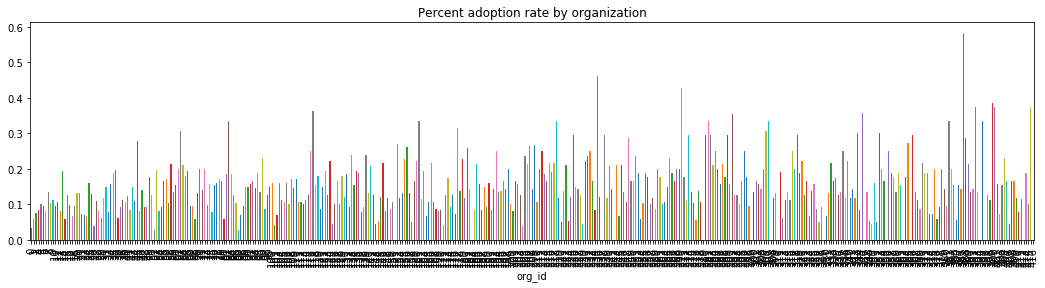

In [168]:
org_id_perc.plot.bar(figsize=(18,4), title='Percent adoption rate by organization')

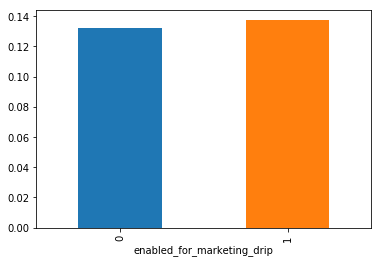

In [162]:
mkt_perc =  (df4.groupby('enabled_for_marketing_drip')['adopted'].sum() / df4.groupby('enabled_for_marketing_drip')['adopted'].count())
mkt_perc.plot.bar()